# Merging high res and low res topograpghy using geoclaw
This code was created by McKay Harward and Adam Robertson to merge a high
resolution topography file with a low resolution bathymetry file.
Specifically in Indonesia for the 1820 earthquake.
This file requires CLAWPACK and its dependencies.

It can be generalized to cut any two low res and high res bathymetry/topography
files, interpolate over the low res file, and finish with a new file at desired
resolution cut to new coordinates. 

It does NOT stitch files together that cover different coordinates.

In [15]:
import matplotlib.pyplot as plt
import clawpack.geoclaw.topotools as topo
import numpy as np
from scipy.interpolate import griddata
# for documentation on topotools please visit http://www.clawpack.org/topotools_module.html

In [16]:
def slice_region(topo_outfile="Tohoku/65_05_2_topo.tt3", bathy_outfile="Tohoku/65_05_2_bathy.tt3", \
    bathy_filename='./Tohoku/tohoku_topo_whitehead.tt3', topo_filename='./Tohoku/srtm_65_05.asc', shore_plots=False, \
    filter=[140,141.15,35,38.1]):
    """
    Takes in two different topography/bathymetry files, returns cutouts of those
    files at desired coordinates

    Parameters:
        topo_outfile(string): filename for writing out samller topography object
        bathy_outfile(string) : filename for writing out smaller bathymetry object
        bathy_filename(string) : filename to read in bathymetry(or lower resolution file)
        topo_filename(string) : filename to read in topography(or higher resolution file)
        shore_plots(bool) : If True, displays shore plots of the two cutout pieces
        filter(list) : Coordinates to create cutout of larger files in form [xlower,xupper,ylower,yupper]

    Note: In some distributions of Topotools the plot function has not been
    updated to new matplotlib standards and will not work. In this case you may
    either plot shores or change source code in topotools.py to the correct parameter
    """
    # Create instance of Topography class for topo file and bathymetry file
    topo_file = topo.Topography()
    bathy_file = topo.Topography()

    # read in topography and bathymetry files

    topo_file.read(topo_filename, topo_type=3)    # high res topography with -9999 values on sea
    bathy_file.read(bathy_filename, topo_type=3)  # low res bathymetry and topography
    # specify topo_type(format) for your files
    # topotools has a built in function to tell you topo_type of any file if needed

    # Crop both files to the same coordinates, [xlower,xupper,ylower,yupper]
    bathy_small = bathy_file.crop(filter_region=filter)
    topo_small = topo_file.crop(filter_region=bathy_small.extent)

    # At this point I recommend creating a shoreline and plotting to verify filter region cut
    if shore_plots == True:
        # Create shorelines in 2xn matrix
        shore_topo_small = topo_small.make_shoreline_xy()
        shore_bathy_small = bathy_small.make_shoreline_xy()
        # Plot both shorelines next to each other
        plt.subplot(221)
        plt.plot(shore_topo_small[:,0],shore_topo_small[:,1])
        plt.subplot(222)
        plt.plot(shore_bathy_small[:,0],shore_bathy_small[:,1])
        plt.show()

    # Write out both files for use in interpolation written by Adam Robertson
    bathy_small.write(bathy_outfile, topo_type=3) # low res
    topo_small.write(topo_outfile, topo_type=3)   # high res

In [17]:
def test_plot(filename='./Tohoku/65_05_1_bathy.tt3', shores=False):
    """
    Multipurpose function to plot any topography/bathymetry file with a normal plot
    or shoreline plot

    Parameters:
        filename(string) : name of file you want to plot
        shores(bool) : whether it should plot shores(True) or full map(False)

    Note: In some distributions of Topotools the plot function has not been
    updated to new matplotlib standards and will not work. In this case you may
    either plot shores or change source code in topotools.py to the correct parameter
    """
    # Read in topography/bathymetry
    test = topo.Topography()
    test.read(filename)
    # If shores is False, normal plot
    if shores == False:
        test.plot()
    # If shores is true, plot shoreline graph
    else:
        shore_test = test.make_shoreline_xy()
        plt.plot(shore_test[:,0], shore_test[:,1])
    plt.show()

In [18]:
def overlay(topo_filename='Tohoku/65_05_1_topo.tt3', bathy_filename='Tohoku/65_05_1_wiped.tt3', \
outfile='65_05_1_merged.tt3', nan_value="-9.9990000e+03"):
    """
    Function to merge interpolated lower resolution bathymetry(or any) and high
    res topography, writes out file.

    Parameters:
        topo_filename(string) : filename to read in topography(or higher resolution file)
        bathy_filename(string) : interpolated filename to read in bathymetry(or lower resolution file)
        outfile(string) : filename for writing out smaller bathymetry object
        nan_value(string) : Nan used in topography file to overwrite

    """
    # Read in both files
    with open(bathy_filename, 'r') as infile:
        data_bathy = [[n for n in line.split()] for line in infile.readlines()]
    with open(topo_filename, 'r') as infile:
        data_topo = [[n for n in line.split()] for line in infile.readlines()]
    # Replace nan's in topo file with values form bathymetry file
    for i in range(len(data_topo)):
        for j in range(len(data_topo[i])):
            if data_topo[i][j] == nan_value: # Put your topography nan value here
                data_topo[i][j] = data_bathy[i][j] # +20 is to offset a shift we noticed in every file

    # write out merged file
    with open(outfile, 'w') as f:
        for i in range(len(data_topo)):
            for j in range(len(data_topo[i])):
                print(data_topo[i][j], end=' ', file=f)
            print("", file=f)

In [19]:
def wipeout_topo(filename='Tohoku/65_05_1_bathy_interpolated.tt3',outfile="Tohoku/65_05_1_wiped.tt3", val="-2"):
    """
    Function to take interpolated bathymetry file and set all values above sea
    level to predefined number that defaults to -2

    Parameters:
        filename(string) : Name of file to level anyhting above sea level
        outfile(string) : Filename to write out finished product
        val(string) : value to set topography equal to. String under ascii formatting
    """
    with open(filename, 'r') as infile:
        data = [[n for n in line.split()] for line in infile.readlines()]
    for i in range(len(data[7:])):
        for j in range(len(data[i+7])):
            if float(data[i+7][j]) >= 0:
                data[i+7][j] = val
    with open(outfile, 'w') as f:
        for i in range(len(data)):
            for j in range(len(data[i])):
                print(data[i][j], end=' ', file=f)
            print("", file=f)
            

In [20]:
def interpolate(in_filename, res_in, out_filename, res_out):
    """Interpolates between the values in input file to produce a new file to
    the specified interpolation.

    Ex: interpolate("etopo.tt3", 60, "banda.tt3", 3)

    Parameters:
        in_file (string): the name of the file to interpolate
        res_in (int): the resolution of the input file (in arc_seconds). Must be larger than res_out
        out_file (string): the name of the new file with higher resolution
        res_out (int): the desired resolution of the output file (in arc_seconds)

    Raises:
        ValueError: incorrect resolution input
    """
    # Check input
    if type(res_in) != int or type(res_out) != int:
        print("USAGE: input_filename, resolution_in, output_filename, resolution_out")
        raise ValueError("Resolutions must be integers.")
    if res_in < 1 or res_out < 1:
        print("USAGE: input_filename, resolution_in, output_filename, resolution_out")
        raise ValueError("Invalid resolution.")
    if res_in < res_out:
        print("USAGE: input_filename, resolution_in, output_filename, resolution_out")
        raise ValueError("Resolutions measured in arcseconds. resolution_in must be a larger integer than resolution_out.")

    # Read in data from file, store in array
    with open(in_filename, 'r') as infile:
        data = infile.readlines()
    # Separate header and data of file
    header = data[:6]
    data = data[6:]
    # Convert data into numpy array
    data = [[int(float(n)) for n in line.split()] for line in data]
    data = np.array(data)
    # Stack data into matrix
    values = np.hstack(data)
    # Compute scale to multiply length and width of original array by to generate size of higher resolution array
    scale = res_in // res_out
    # Store size of original data array
    x = len(data)
    y = len(data[0])
    # Create an array of arrays to represent points in grid (used in griddata)
    # Create matrix of the form: [ [0,0], [0,1], [0,2], ..., [0,y],
    #                              [1,0], [1,1], [1,2], ..., [1,y],
    #                              ...
    #                              [x,0], [x,1], [x,2], ..., [x,y] ]
    points = np.array([[0,0]])
    for i in np.linspace(0, len(data), len(data)):
        for j in np.linspace(0,len(data[0]), len(data[0])):
            points = np.append(points, [[i, j]], axis=0)
    # Remove duplicate [0,0] vector
    points = points[1:]
    # Mesh grid
    grid_x, grid_y = np.mgrid[0:len(data):complex(x*scale), 0:len(data[0]):complex(y*scale)]
    # Use scipy.interpolate.griddata to interpolate data over points
    grid = griddata(points, values, (grid_x, grid_y), method="linear")
    # Create header string to include in output file
    # In the current version, the header in the output file is exactly the same as the header in the input file.
    hstring = str()
    for i in header:
        hstring += i
    hstring = hstring[:-1]
    # Write data and header to output file
    np.savetxt(out_filename, grid, delimiter='   ', header=hstring, comments="")

Format for cutting region [xlower,xupper,ylower,yupper]

## Coordinates to evaluate for Indonesia  
Gauge 10001:
* [-5.13, 119.41] 
* srtm_60_14   
* [119.31, 119.41, -5.26, -5.08]
* Makassar

Gauge 10002:
* [-5.33, 120.22] 
* srtm_61_14   
* [120.35, 120.43,-5.61 ,-5.52 ] 
* Fort Bulekomba

Gauge 10003:
* [-5.56, 120.20] 
* srtm_61_14   
* [120.15, 120.23, -.5.58, -5.54] 
* Terang-Terang

Gauge 10004:
* [-5.56, 120.01] 
* srtm_61_14   
* [119.95, 120.08, -5.59,-5.54 ] 
* Nipa-Nipa

Gauge 10005:
* [-8.46, 118.72] 
* srtm_60_14   
* [118.67, 118.73 , -8.52, -8.33] 
* Bima

Gauge 10006:
* [-8.33, 121.71] 
* srtm_61_14   
* [121.68, 121.75, -8.36, -8.29] 
* Paloweh

Gauge 10007:
* [-7.04, 113.89] 
* srtm_59_14  
* [113.87, 114.10, -7.14, -7.01] 
* Sumenep


## 1. Makassar

*** Note: since grid registration is llcorner,
    will shift x,y values by (dx/2, dy/2) to cell centers
*** Note: since grid registration is llcorner,
    will shift x,y values by (dx/2, dy/2) to cell centers


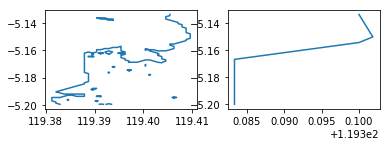

In [21]:
# cut smaller sections out of the bathymetry and the topography files
slice_region(topo_outfile="Example/maka_topo.tt3", bathy_outfile="Example/maka_bathy.tt3", \
    bathy_filename='./etopo1.tt3', topo_filename='./srtm_60_14.tt3', shore_plots=True, \
    filter=[119.35, 119.425, -5.2, -5.12])

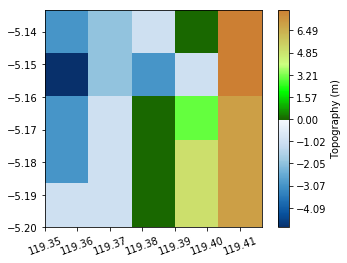

In [22]:
# Bathymetry, this comes from our NOAA file titled etopo1.tt3
test_plot("Example/maka_bathy.tt3")

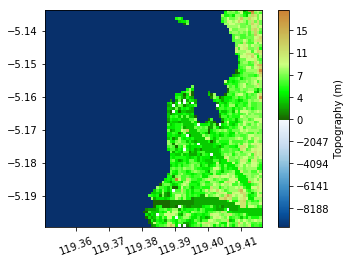

In [23]:
# Topography, this comes from our SRTM file titled srtm_60_14.tt3
test_plot("Example/maka_topo.tt3")

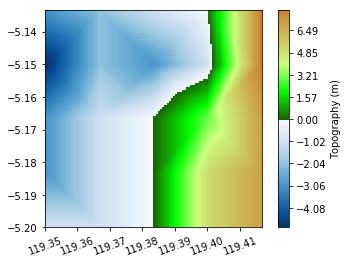

In [24]:
# now we interpolate the bathymetry file above to a higher resolution
interpolate(in_filename="Example/maka_bathy.tt3", res_in=60, out_filename="Example/interpolated_maka_bathy.tt3", res_out=3)
# plot what we just did
test_plot("Example/interpolated_maka_bathy.tt3")

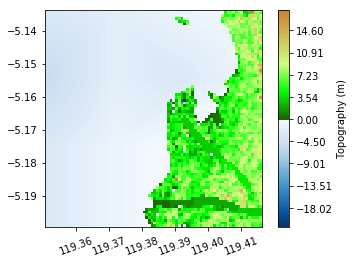

In [25]:
# we're going to overlay our files now without wiping out topography to make sure they line up correctly
overlay(topo_filename='Example/maka_topo.tt3', bathy_filename='Example/interpolated_maka_bathy.tt3', \
outfile='Example/maka_test.tt3', nan_value="-9.9990000e+03")

# we then plot what we did
test_plot('Example/maka_test.tt3')

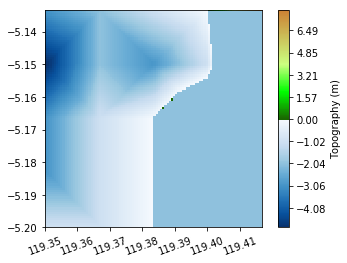

In [26]:
# we now wipeout the topography on the banda file to make ocean what should be ocean, setting this equal to -2
wipeout_topo(filename='Example/interpolated_maka_bathy.tt3',outfile="Example/interpolated_maka_wiped.tt3", val="-2")
test_plot("Example/interpolated_maka_wiped.tt3")

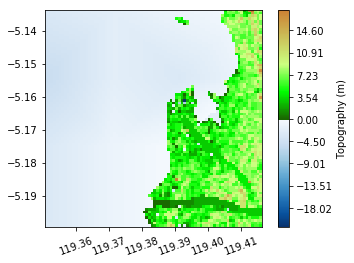

In [27]:
# finally overlay to get our final product
overlay(topo_filename='Example/maka_topo.tt3', bathy_filename='Example/interpolated_maka_wiped.tt3', \
outfile='Example/maka_merged.tt3', nan_value="-9.9990000e+03")

# we then plot what we did
test_plot('Example/maka_merged.tt3')

## 2. Fort Bulekomba

*** Note: since grid registration is llcorner,
    will shift x,y values by (dx/2, dy/2) to cell centers
*** Note: since grid registration is llcorner,
    will shift x,y values by (dx/2, dy/2) to cell centers


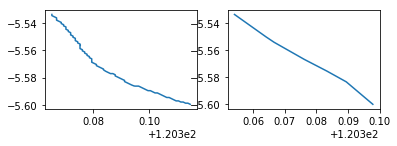

In [28]:
# cut smaller sections out of the bathymetry and the topography files
slice_region(topo_outfile="Example/bul_topo.tt3", bathy_outfile="Example/bul_bathy.tt3", \
    bathy_filename='./etopo1.tt3', topo_filename='./srtm_61_14.tt3', shore_plots=True, \
    filter=[120.35, 120.43,-5.61 ,-5.52 ])

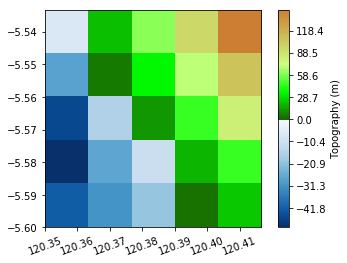

In [29]:
# Bathymetry, this comes from our NOAA file titled etopo1.tt3
test_plot("Example/bul_bathy.tt3")

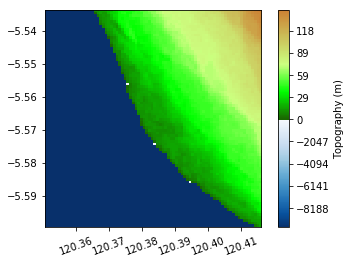

In [30]:
# Topography, this comes from our SRTM file titled srtm_61_14.tt3
test_plot("Example/bul_topo.tt3")

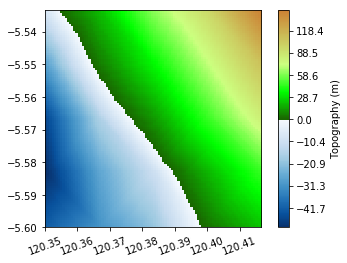

In [31]:
# now we interpolate the bathymetry file above to a higher resolution
interpolate(in_filename="Example/bul_bathy.tt3", res_in=60, out_filename="Example/interpolated_bul_bathy.tt3", res_out=3)
# plot what we just did
test_plot("Example/interpolated_bul_bathy.tt3")

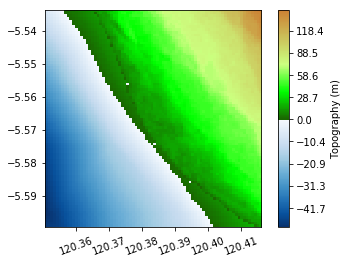

In [32]:
# we're going to overlay our files now without wiping out topography to make sure they line up correctly
overlay(topo_filename='Example/bul_topo.tt3', bathy_filename='Example/interpolated_bul_bathy.tt3', \
outfile='Example/bul_test.tt3', nan_value="-9.9990000e+03")

# we then plot what we did
test_plot('Example/bul_test.tt3')

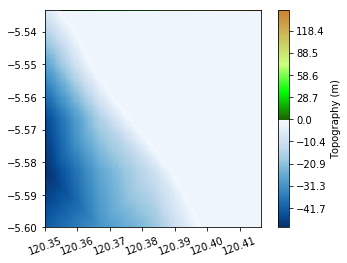

In [33]:
# we now wipeout the topography on the banda file to make ocean what should be ocean, setting this equal to -2
wipeout_topo(filename='Example/interpolated_bul_bathy.tt3',outfile="Example/interpolated_bul_wiped.tt3", val="-2")
test_plot("Example/interpolated_bul_wiped.tt3")

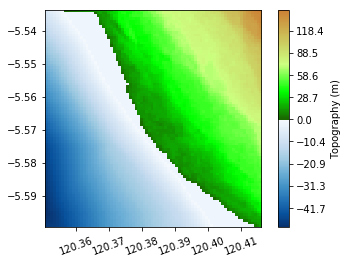

In [34]:
# finally overlay to get our final product
overlay(topo_filename='Example/bul_topo.tt3', bathy_filename='Example/interpolated_bul_wiped.tt3', \
outfile='Example/bul_merged.tt3', nan_value="-9.9990000e+03")

# we then plot what we did
test_plot('Example/bul_merged.tt3')

## 3. Terang-Terang

*** Note: since grid registration is llcorner,
    will shift x,y values by (dx/2, dy/2) to cell centers
*** Note: since grid registration is llcorner,
    will shift x,y values by (dx/2, dy/2) to cell centers


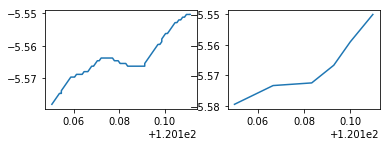

In [35]:
# cut smaller sections out of the bathymetry and the topography files
slice_region(topo_outfile="Example/tera_topo.tt3", bathy_outfile="Example/tera_bathy.tt3", \
    bathy_filename='./etopo1.tt3', topo_filename='./srtm_61_14.tt3', shore_plots=True, \
    filter=[120.15, 120.23, -5.62, -5.54])

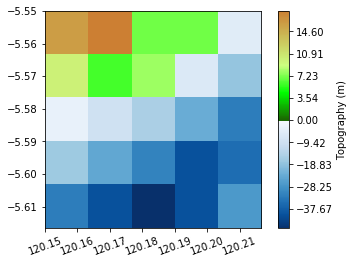

In [36]:
# Bathymetry, this comes from our NOAA file titled etopo1.tt3
test_plot("Example/tera_bathy.tt3")

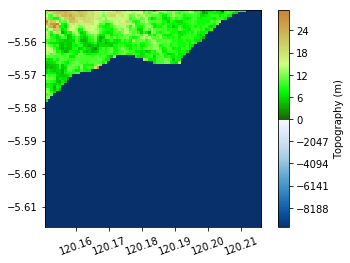

In [37]:
# Topography, this comes from our SRTM file titled srtm_61_14.tt3
test_plot("Example/tera_topo.tt3")

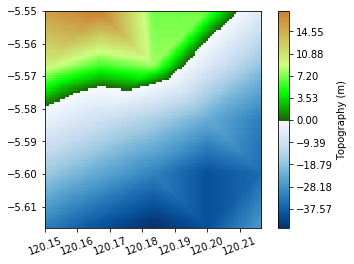

In [38]:
# now we interpolate the bathymetry file above to a higher resolution
interpolate(in_filename="Example/tera_bathy.tt3", res_in=60, out_filename="Example/interpolated_tera_bathy.tt3", res_out=3)
# plot what we just did
test_plot("Example/interpolated_tera_bathy.tt3")

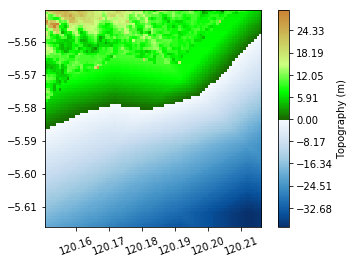

In [39]:
# we're going to overlay our files now without wiping out topography to make sure they line up correctly
overlay(topo_filename='Example/tera_topo.tt3', bathy_filename='Example/interpolated_tera_bathy.tt3', \
outfile='Example/tera_test.tt3', nan_value="-9.9990000e+03")

# we then plot what we did
test_plot('Example/tera_test.tt3')

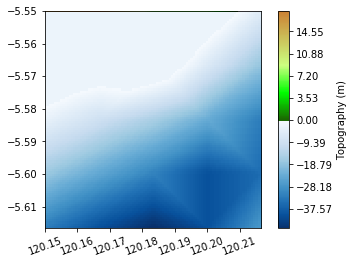

In [40]:
# we now wipeout the topography on the banda file to make ocean what should be ocean, setting this equal to -2
wipeout_topo(filename='Example/interpolated_tera_bathy.tt3',outfile="Example/interpolated_tera_wiped.tt3", val="-2")
test_plot("Example/interpolated_tera_wiped.tt3")

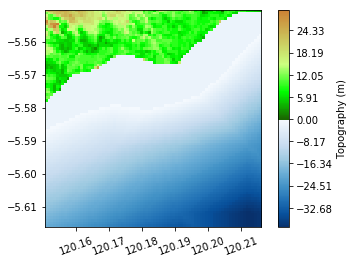

In [41]:
# finally overlay to get our final product
overlay(topo_filename='Example/tera_topo.tt3', bathy_filename='Example/interpolated_tera_wiped.tt3', \
outfile='Example/tera_merged.tt3', nan_value="-9.9990000e+03")

# we then plot what we did
test_plot('Example/tera_merged.tt3')

## 4. Nipa-Nipa

*** Note: since grid registration is llcorner,
    will shift x,y values by (dx/2, dy/2) to cell centers
*** Note: since grid registration is llcorner,
    will shift x,y values by (dx/2, dy/2) to cell centers


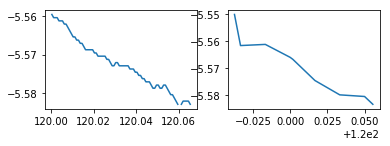

In [42]:
# cut smaller sections out of the bathymetry and the topography files
slice_region(topo_outfile="Example/nipa_topo.tt3", bathy_outfile="Example/nipa_bathy.tt3", \
    bathy_filename='./etopo1.tt3', topo_filename='./srtm_61_14.tt3', shore_plots=True, \
    filter=[119.95, 120.08, -5.59,-5.54 ])

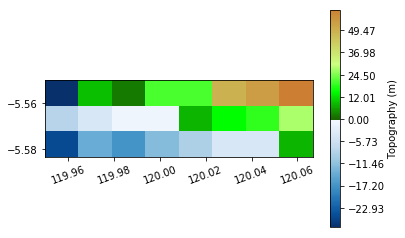

In [43]:
# Bathymetry, this comes from our NOAA file titled etopo1.tt3
test_plot("Example/nipa_bathy.tt3")

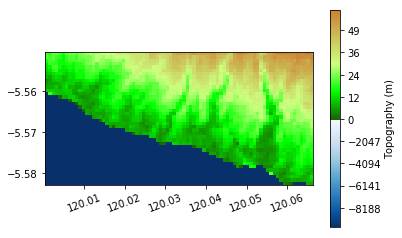

In [44]:
# Topography, this comes from our SRTM file titled srtm_61_14.tt3
test_plot("Example/nipa_topo.tt3")

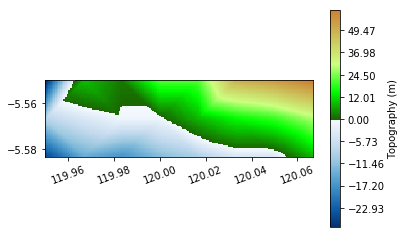

In [45]:
# now we interpolate the bathymetry file above to a higher resolution
interpolate(in_filename="Example/nipa_bathy.tt3", res_in=60, out_filename="Example/interpolated_nipa_bathy.tt3", res_out=3)
# plot what we just did
test_plot("Example/interpolated_nipa_bathy.tt3")

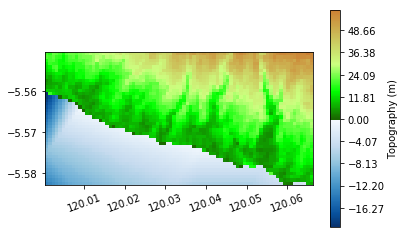

In [46]:
# we're going to overlay our files now without wiping out topography to make sure they line up correctly
overlay(topo_filename='Example/nipa_topo.tt3', bathy_filename='Example/interpolated_nipa_bathy.tt3', \
outfile='Example/nipa_test.tt3', nan_value="-9.9990000e+03")

# we then plot what we did
test_plot('Example/nipa_test.tt3')

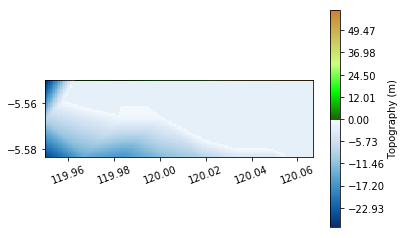

In [47]:
# we now wipeout the topography on the banda file to make ocean what should be ocean, setting this equal to -2
wipeout_topo(filename='Example/interpolated_nipa_bathy.tt3',outfile="Example/interpolated_nipa_wiped.tt3", val="-2")
test_plot("Example/interpolated_nipa_wiped.tt3")

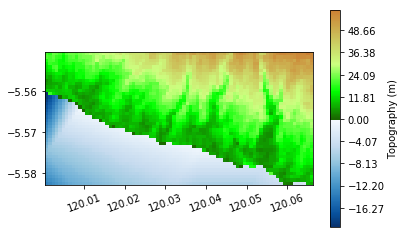

In [48]:
# finally overlay to get our final product
overlay(topo_filename='Example/nipa_topo.tt3', bathy_filename='Example/interpolated_nipa_wiped.tt3', \
outfile='Example/nipa_merged.tt3', nan_value="-9.9990000e+03")

# we then plot what we did
test_plot('Example/nipa_merged.tt3')

## 5. Bima

*** Note: since grid registration is llcorner,
    will shift x,y values by (dx/2, dy/2) to cell centers
*** Note: since grid registration is llcorner,
    will shift x,y values by (dx/2, dy/2) to cell centers


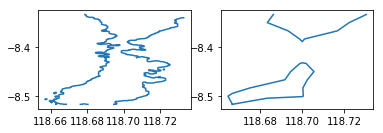

In [49]:
# cut smaller sections out of the bathymetry and the topography files
slice_region(topo_outfile="Example/bima_topo.tt3", bathy_outfile="Example/bima_bathy.tt3", \
    bathy_filename='./etopo1.tt3', topo_filename='./srtm_60_14.tt3', shore_plots=True, \
    filter=[118.65, 118.75 , -8.52, -8.33])

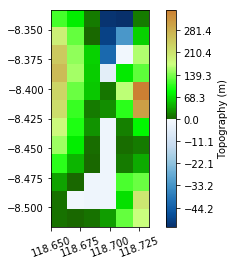

In [50]:
# Bathymetry, this comes from our NOAA file titled etopo1.tt3
test_plot("Example/bima_bathy.tt3")

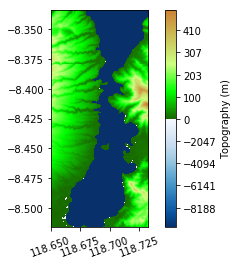

In [51]:
# Topography, this comes from our SRTM file titled srtm_60_14.tt3
test_plot("Example/bima_topo.tt3")

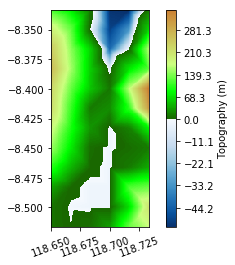

In [52]:
# now we interpolate the bathymetry file above to a higher resolution
interpolate(in_filename="Example/bima_bathy.tt3", res_in=60, out_filename="Example/interpolated_bima_bathy.tt3", res_out=3)
# plot what we just did
test_plot("Example/interpolated_bima_bathy.tt3")

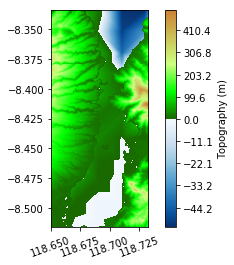

In [53]:
# we're going to overlay our files now without wiping out topography to make sure they line up correctly
overlay(topo_filename='Example/bima_topo.tt3', bathy_filename='Example/interpolated_bima_bathy.tt3', \
outfile='Example/bima_test.tt3', nan_value="-9.9990000e+03")

# we then plot what we did
test_plot('Example/bima_test.tt3')

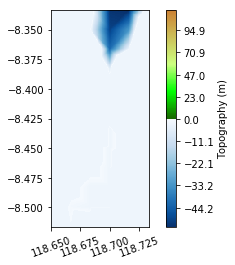

In [54]:
# we now wipeout the topography on the banda file to make ocean what should be ocean, setting this equal to -2
wipeout_topo(filename='Example/interpolated_bima_bathy.tt3',outfile="Example/interpolated_bima_wiped.tt3", val="-2")
test_plot("Example/interpolated_bima_wiped.tt3")

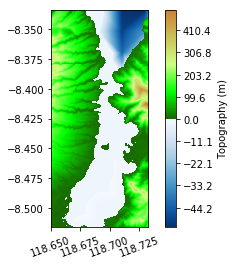

In [55]:
# finally overlay to get our final product
overlay(topo_filename='Example/bima_topo.tt3', bathy_filename='Example/interpolated_bima_wiped.tt3', \
outfile='Example/bima_merged.tt3', nan_value="-9.9990000e+03")

# we then plot what we did
test_plot('Example/bima_merged.tt3')

## 6. Paloweh

*** Note: since grid registration is llcorner,
    will shift x,y values by (dx/2, dy/2) to cell centers
*** Note: since grid registration is llcorner,
    will shift x,y values by (dx/2, dy/2) to cell centers


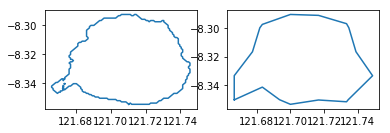

In [56]:
# cut smaller sections out of the bathymetry and the topography files
slice_region(topo_outfile="Example/palo_topo.tt3", bathy_outfile="Example/palo_bathy.tt3", \
    bathy_filename='./etopo1.tt3', topo_filename='./srtm_61_14.tt3', shore_plots=True, \
    filter=[121.64, 121.78, -8.38, -8.28])

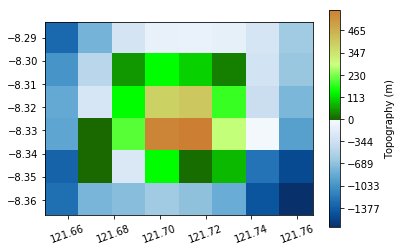

In [57]:
# Bathymetry, this comes from our NOAA file titled etopo1.tt3
test_plot("Example/palo_bathy.tt3")

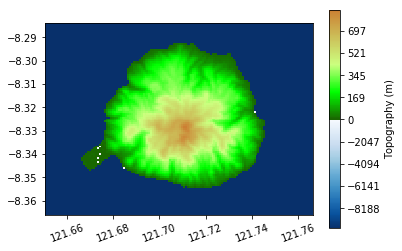

In [58]:
# Topography, this comes from our SRTM file titled srtm_61_14.tt3
test_plot("Example/palo_topo.tt3")

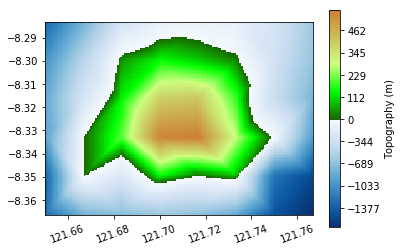

In [59]:
# now we interpolate the bathymetry file above to a higher resolution
interpolate(in_filename="Example/palo_bathy.tt3", res_in=60, out_filename="Example/interpolated_palo_bathy.tt3", res_out=3)
# plot what we just did
test_plot("Example/interpolated_palo_bathy.tt3")

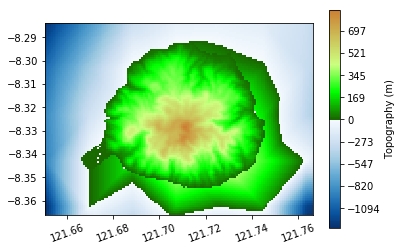

In [60]:
# we're going to overlay our files now without wiping out topography to make sure they line up correctly
overlay(topo_filename='Example/palo_topo.tt3', bathy_filename='Example/interpolated_palo_bathy.tt3', \
outfile='Example/palo_test.tt3', nan_value="-9.9990000e+03")

# we then plot what we did
test_plot('Example/palo_test.tt3')

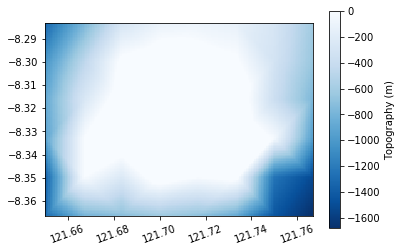

In [61]:
# we now wipeout the topography on the banda file to make ocean what should be ocean, setting this equal to -2
wipeout_topo(filename='Example/interpolated_palo_bathy.tt3',outfile="Example/interpolated_palo_wiped.tt3", val="-2")
test_plot("Example/interpolated_palo_wiped.tt3")

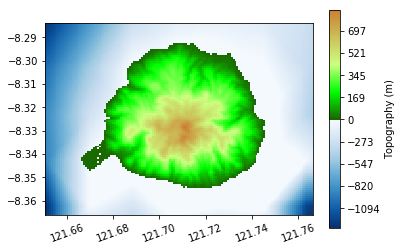

In [62]:
# finally overlay to get our final product
overlay(topo_filename='Example/palo_topo.tt3', bathy_filename='Example/interpolated_palo_wiped.tt3', \
outfile='Example/palo_merged.tt3', nan_value="-9.9990000e+03")

# we then plot what we did
test_plot('Example/palo_merged.tt3')

## 7. Sumenep

*** Note: since grid registration is llcorner,
    will shift x,y values by (dx/2, dy/2) to cell centers
*** Note: since grid registration is llcorner,
    will shift x,y values by (dx/2, dy/2) to cell centers


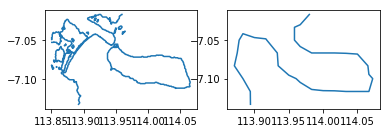

In [63]:
# cut smaller sections out of the bathymetry and the topography files
slice_region(topo_outfile="Example/sume_topo.tt3", bathy_outfile="Example/sume_bathy.tt3", \
    bathy_filename='./etopo1.tt3', topo_filename='./srtm_59_14.tt3', shore_plots=True, \
    filter=[113.85, 114.10, -7.14, -7.01])

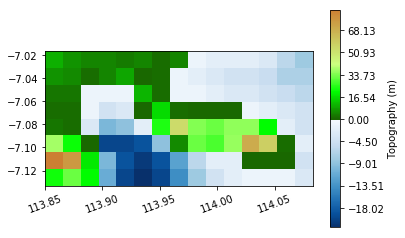

In [64]:
# Bathymetry, this comes from our NOAA file titled etopo1.tt3
test_plot("Example/sume_bathy.tt3")

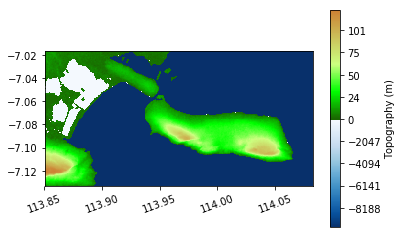

In [65]:
# Topography, this comes from our SRTM file titled srtm_59_14.tt3
test_plot("Example/sume_topo.tt3")

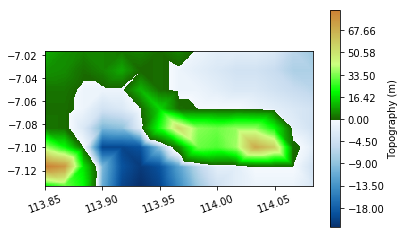

In [66]:
# now we interpolate the bathymetry file above to a higher resolution
interpolate(in_filename="Example/sume_bathy.tt3", res_in=60, out_filename="Example/interpolated_sume_bathy.tt3", res_out=3)
# plot what we just did
test_plot("Example/interpolated_sume_bathy.tt3")

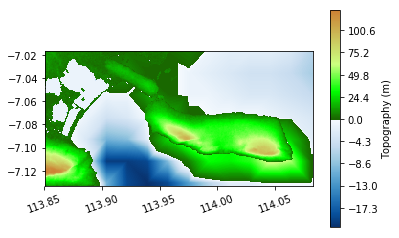

In [67]:
# we're going to overlay our files now without wiping out topography to make sure they line up correctly
overlay(topo_filename='Example/sume_topo.tt3', bathy_filename='Example/interpolated_sume_bathy.tt3', \
outfile='Example/sume_test.tt3', nan_value="-9.9990000e+03")

# we then plot what we did
test_plot('Example/sume_test.tt3')

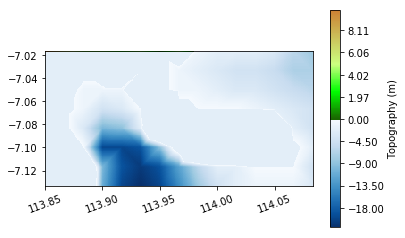

In [68]:
# we now wipeout the topography on the banda file to make ocean what should be ocean, setting this equal to -2
wipeout_topo(filename='Example/interpolated_sume_bathy.tt3',outfile="Example/interpolated_sume_wiped.tt3", val="-2")
test_plot("Example/interpolated_sume_wiped.tt3")

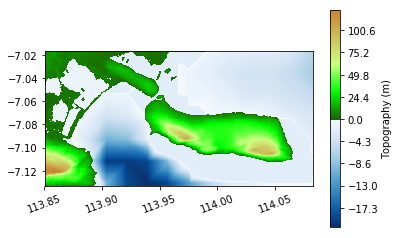

In [69]:
# finally overlay to get our final product
overlay(topo_filename='Example/sume_topo.tt3', bathy_filename='Example/interpolated_sume_wiped.tt3', \
outfile='Example/sume_merged.tt3', nan_value="-9.9990000e+03")

# we then plot what we did
test_plot('Example/sume_merged.tt3')